<a href="https://colab.research.google.com/github/Bolorooo24/Natural_Language_processing/blob/main/Tweet_Emotion_Recognition_Learner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tweet Emotion Recognition: Natural Language Processing with TensorFlow

---

Dataset: [Tweet Emotion Dataset](https://github.com/dair-ai/emotion_dataset)


---

## Task 1: Introduction

## Task 2: Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [3]:
!git clone https://github.com/Bolorooo24/Natural_Language_processing.git

fatal: destination path 'Natural_Language_processing' already exists and is not an empty directory.


In [ ]:
!pip install nlp

In [5]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()


print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.12.0


## Task 3: Importing Data

1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [ ]:
!pip install datasets




In [ ]:
import datasets

dataset = datasets.load_dataset('dair-ai/emotion')


In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [10]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [11]:
tweets, labels = get_tweet(train)

In [12]:
tweets[0], labels[0]

('i didnt feel humiliated', 0)

## Task 4: Tokenizer

1. Tokenizing the tweets

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [14]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [15]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

## Task 5: Padding and Truncating Sequences

1. Checking length of the tweets
2. Creating padded sequences

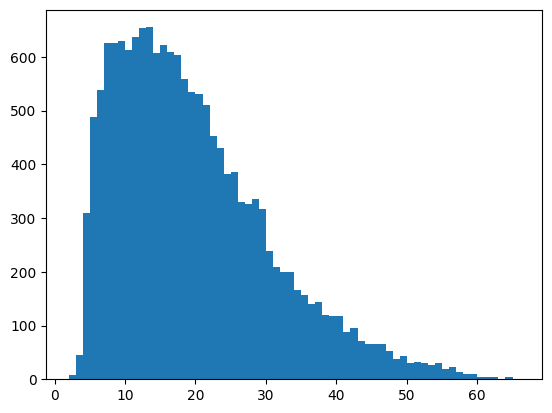

In [16]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

In [17]:
maxlen = 50


In [18]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=50)
  return padded


In [19]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [20]:
padded_train_seq[10]

array([  2,   3,  14,   2,  21,   5,  80,   6, 733,   2,  93, 544, 304,
        84,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Task 6: Preparing the Labels

1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [21]:
classes = set(labels)
classes

{0, 1, 2, 3, 4, 5}

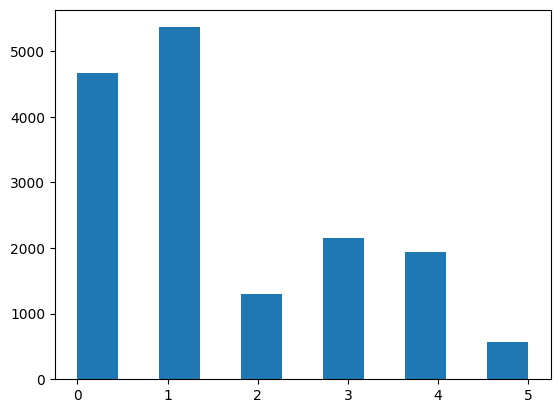

In [22]:
plt.hist(labels, bins = 11)
plt.show()

In [23]:
# if labels are not numeric value
classes_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in classes_to_index.items())

In [24]:
names_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [25]:
train_labels = names_to_ids(labels)
train_labels

array([0, 0, 3, ..., 1, 3, 0])

## Task 7: Creating the Model

1. Creating the model
2. Compiling the model

In [26]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length = 50),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation = 'softmax')
])
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Task 8: Training the Model

1. Preparing a validation set
2. Training the model

In [28]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = names_to_ids(val_labels)

In [29]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

In [30]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs = 20,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 53s 65ms/step - loss: 1.2555 - accuracy: 0.5124 - val_loss: 0.7780 - val_accuracy: 0.7095
Epoch 2/20
500/500 [==============================] - 9s 19ms/step - loss: 0.5487 - accuracy: 0.7955 - val_loss: 0.5532 - val_accuracy: 0.8110
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3167 - accuracy: 0.8946 - val_loss: 0.4863 - val_accuracy: 0.8510
Epoch 4/20
500/500 [==============================] - 8s 17ms/step - loss: 0.2198 - accuracy: 0.9291 - val_loss: 0.4575 - val_accuracy: 0.8570
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.1751 - accuracy: 0.9448 - val_loss: 0.4994 - val_accuracy: 0.8615
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1422 - accuracy: 0.9554 - val_loss: 0.4435 - val_accuracy: 0.8700
Epoch 7/20
500/500 [==============================] - 8s 15ms/step - loss: 0.1151 - accuracy: 0.9625 - val_loss: 0.4637 - val_accuracy: 0.877

## Task 9: Evaluating the Model

1. Visualizing training history
2. Prepraring a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

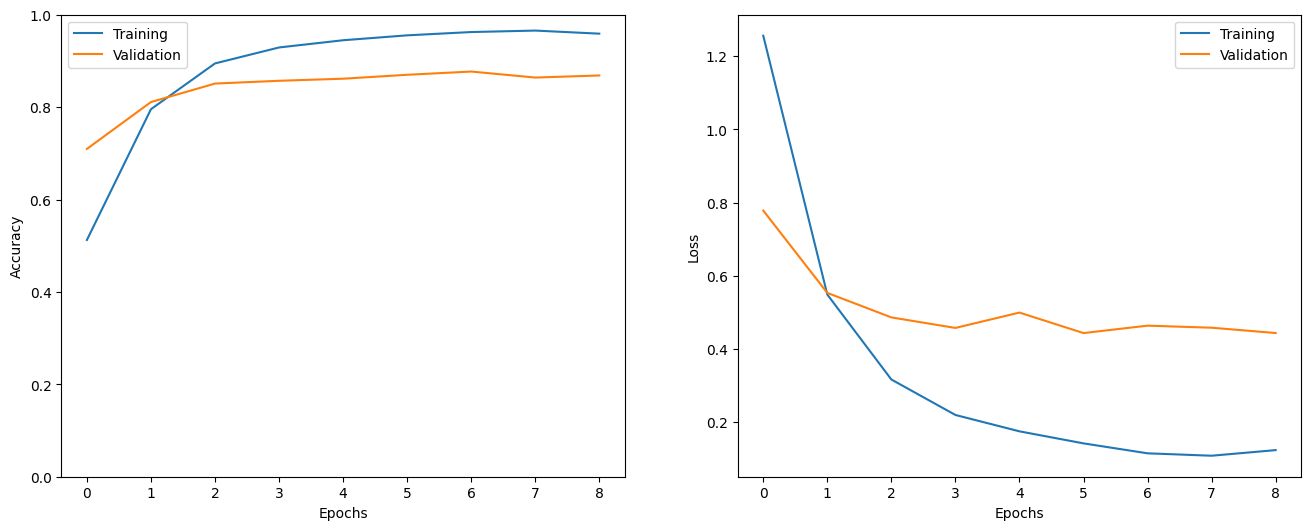

In [31]:
show_history(h)

In [32]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = names_to_ids(test_labels)

In [33]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4580 - accuracy: 0.8660


In [37]:
i = random.randint(0, len(test_labels)-1)

print('Sentence: ', test_tweets[i])
print('Emotion: ', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted emotion: ', pred_class)

Sentence:  i feel like it is so important for me to publicly bless my virus
Emotion:  1
1/1 [==============================] - 0s 32ms/step
Predicted emotion:  1


In [35]:
preds = model.predict(test_seq)
predicted_classes = np.argmax(preds, axis=1)


63/63 [==============================] - 0s 5ms/step


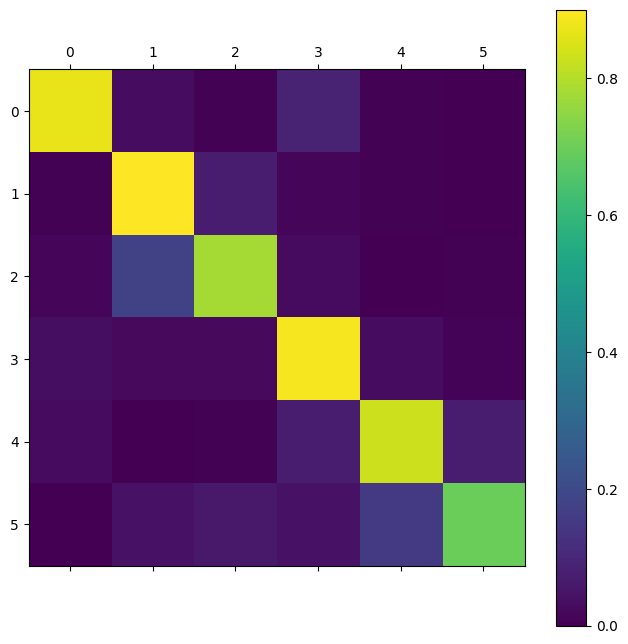

In [36]:
show_confusion_matrix(test_labels, predicted_classes, list(classes))
